In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models  

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm, trange
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, accuracy_score  
import seaborn as sns


In [39]:
class Config:
    data_dir = "D:\\Leko\\medical_model\\task1\\dataset\\images"
    label_csv = "D:\\Leko\\medical_model\\task1\\dataset\\labels.csv"
    img_size = 224
    batch_size = 32
    epochs = 30
    lr = 1e-4  # ✅ ResNet34 推荐使用略高的学习率（如 5e-4 或 1e-4）
    num_workers = 0  # ✅ 增加 num_workers 提升加载速度
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "resnet50"  # ✅ 替换为 ResNet34
    save_dir = "./output"
    seed = 42

torch.manual_seed(Config.seed)
os.makedirs(Config.save_dir, exist_ok=True)

In [40]:
class TumorDataset(Dataset):
    def __init__(self, df, img_dir, train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = np.array(Image.open(img_path).convert('RGB'))
        label = int(row['label'])

        # ✅ 根据训练 or 验证阶段选择 transform
        if self.train:
            transform = get_transforms(train=True, is_tumor=(label == 1))
        else:
            transform = get_transforms(train=False)

        image = transform(image=image)['image']
        return image, label


In [41]:
class CutMixCollator:
    def __init__(self, beta=1.0, prob=0.5):
        self.beta = beta
        self.prob = prob

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.tensor(labels).float().view(-1, 1)  # ✅ 修复维度问题

        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.beta, self.beta)
        batch_size = images.size(0)
        index = torch.randperm(batch_size)

        mixed_images = lam * images + (1 - lam) * images[index]
        mixed_labels = lam * labels + (1 - lam) * labels[index]
        return mixed_images, mixed_labels



class MixUpCollator:
    def __init__(self, alpha=0.4, prob=0.5):
        self.alpha = alpha
        self.prob = prob

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.tensor(labels).float().view(-1, 1)


        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.alpha, self.alpha)
        index = torch.randperm(images.size(0))
        mixed_images = lam * images + (1 - lam) * images[index]
        labels = lam * labels + (1 - lam) * labels[index]
        return mixed_images, labels


In [42]:
def get_transforms(train=True, is_tumor=False):
    if train:
        base = [
            A.Resize(Config.img_size, Config.img_size),
            A.HorizontalFlip(p=0.5),
        ]
        if is_tumor:
            base += [
                A.RandomBrightnessContrast(p=0.5),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
                A.CoarseDropout(p=0.3)
            ]
        base += [
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ]
        return A.Compose(base)
    else:
        return A.Compose([
            A.Resize(Config.img_size, Config.img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])


In [43]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) 加载预训练 ResNet34，去掉原来的 fc
        backbone = models.resnet50(pretrained=True)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

        self.backbone = backbone
        # 2) 基础分类头：一层 Linear，输出 (B,1)
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        # backbone 输出 [B, 512]
        features = self.backbone(x)
        # classifier 输出 [B, 1]
        out = self.classifier(features)
        return out


In [44]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()


In [45]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(Config.device)
        labels = labels.float().unsqueeze(1).to(Config.device)  # [B,1]
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)        # [B,1]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

In [46]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(Config.device)
            labels = labels.float().unsqueeze(1).to(Config.device)  # 已正确处理

            with autocast():
                outputs = model(images)    # [B,1]
                loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds.extend(probs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return total_loss / len(loader), np.array(preds), np.array(targets)

In [47]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

训练集类别分布：
label
0    7552
1    1816
Name: count, dtype: int64
验证集类别分布：
label
0    1618
1     389
Name: count, dtype: int64
测试集类别分布：
label
0    1619
1     389
Name: count, dtype: int64
🧠 初始化模型中...


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\27361745.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


✅ 模型初始化完成
📊 当前训练集图像分布：正常类 7552，肿瘤类 1816

📘 Epoch 1/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [06:56<00:00,  1.42s/it]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.2110 | Val Loss: 0.2438 | AUC: 0.9355
F1@0.50: 0.7069 | ✅ Best F1@0.35: 0.7514
🎯 Accuracy: 0.9113
🧪 Sensitivity (Recall for tumor): 0.6915
🧪 Specificity (Recall for normal): 0.9642
✅ Best model saved.

📘 Epoch 2/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [06:54<00:00,  1.42s/it]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1538 | Val Loss: 0.2467 | AUC: 0.9382
F1@0.50: 0.7567 | ✅ Best F1@0.56: 0.7596
🎯 Accuracy: 0.9098
🧪 Sensitivity (Recall for tumor): 0.7352
🧪 Specificity (Recall for normal): 0.9518
✅ Best model saved.

📘 Epoch 3/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:59<00:00,  1.22it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1305 | Val Loss: 0.4039 | AUC: 0.9391
F1@0.50: 0.5281 | ✅ Best F1@0.10: 0.7256
🎯 Accuracy: 0.9103
🧪 Sensitivity (Recall for tumor): 0.6118
🧪 Specificity (Recall for normal): 0.9821
✅ Best model saved.

📘 Epoch 4/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:39<00:00,  1.34it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1232 | Val Loss: 0.2887 | AUC: 0.9383
F1@0.50: 0.7141 | ✅ Best F1@0.17: 0.7684
🎯 Accuracy: 0.9138
🧪 Sensitivity (Recall for tumor): 0.7378
🧪 Specificity (Recall for normal): 0.9561

📘 Epoch 5/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:39<00:00,  1.33it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.1139 | Val Loss: 0.3609 | AUC: 0.9322
F1@0.50: 0.5847 | ✅ Best F1@0.11: 0.7592
🎯 Accuracy: 0.9153
🧪 Sensitivity (Recall for tumor): 0.6889
🧪 Specificity (Recall for normal): 0.9697

📘 Epoch 6/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:39<00:00,  1.34it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0875 | Val Loss: 0.3418 | AUC: 0.9366
F1@0.50: 0.6497 | ✅ Best F1@0.10: 0.7605
🎯 Accuracy: 0.9118
🧪 Sensitivity (Recall for tumor): 0.7224
🧪 Specificity (Recall for normal): 0.9574

📘 Epoch 7/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:38<00:00,  1.34it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0873 | Val Loss: 0.3252 | AUC: 0.9319
F1@0.50: 0.6966 | ✅ Best F1@0.18: 0.7686
🎯 Accuracy: 0.9208
🧪 Sensitivity (Recall for tumor): 0.6787
🧪 Specificity (Recall for normal): 0.9790

📘 Epoch 8/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_9676\998478402.py:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.3),
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\2197347249.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:39<00:00,  1.33it/s]
C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.0826 | Val Loss: 0.6391 | AUC: 0.8966
F1@0.50: 0.5491 | ✅ Best F1@0.89: 0.6978
🎯 Accuracy: 0.8839
🧪 Sensitivity (Recall for tumor): 0.6915
🧪 Specificity (Recall for normal): 0.9302
⏹️ Early stopping triggered.


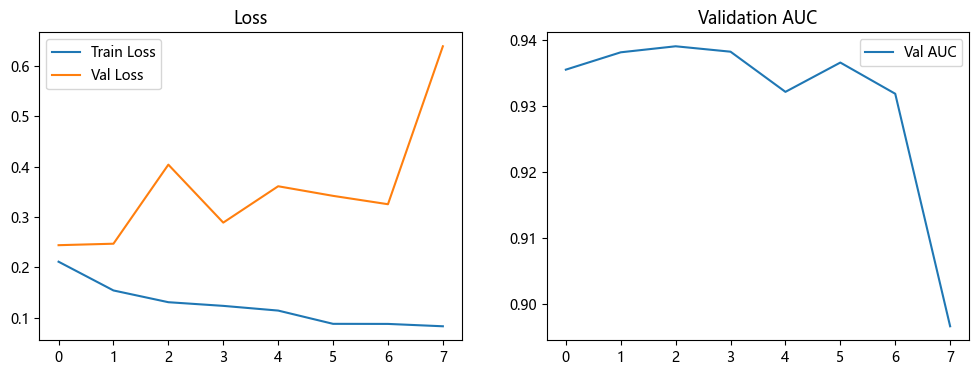

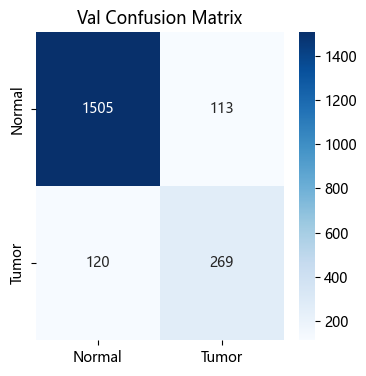

In [48]:
from sklearn.model_selection import train_test_split

# 读取 CSV 标签
full_df = pd.read_csv(Config.label_csv)

# 三分法划分 train / val / test
train_df, tmp_df = train_test_split(
    full_df,
    test_size=0.3,
    stratify=full_df['label'],
    random_state=Config.seed
)
val_df, test_df = train_test_split(
    tmp_df,
    test_size=0.5,
    stratify=tmp_df['label'],
    random_state=Config.seed
)

print(f"训练集类别分布：\n{train_df['label'].value_counts()}")
print(f"验证集类别分布：\n{val_df['label'].value_counts()}")
print(f"测试集类别分布：\n{test_df['label'].value_counts()}")

# 设置增强策略：baseline 不使用 CutMix/MixUp
use_mix_mode = "none"
collate_fn = None

# Baseline 下直接随机打乱，不使用加权采样
sampler = None

# 构建 Dataset 和 DataLoader
train_dataset = TumorDataset(train_df, Config.data_dir, train=True)
val_dataset   = TumorDataset(val_df,   Config.data_dir, train=False)
test_dataset  = TumorDataset(test_df,  Config.data_dir, train=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)

# 初始化模型
print("🧠 初始化模型中...")
model = TumorClassifier().to(Config.device)
print("✅ 模型初始化完成")

optimizer = optim.Adam(
    model.parameters(),
    lr=Config.lr,
    weight_decay=1e-4
)
criterion = nn.BCEWithLogitsLoss()
early_stopper = EarlyStopping(patience=5)
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}
best_auc = 0
best_thresh = 0.5  # 会在训练中更新

# 显示训练集类别分布
train_labels = train_df['label']
print(f"📊 当前训练集图像分布：正常类 {(train_labels == 0).sum()}，肿瘤类 {(train_labels == 1).sum()}")

for epoch in range(Config.epochs):
    print(f"\n📘 Epoch {epoch+1}/{Config.epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, preds, targets = evaluate(model, val_loader, criterion)
    val_auc = roc_auc_score(targets, preds)

    # 最佳 F1 阈值搜索
    val_f1_default = f1_score(targets, (preds >= 0.5).astype(int))
    curr_best_f1, curr_best_thresh = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        f1 = f1_score(targets, (preds >= t).astype(int))
        if f1 > curr_best_f1:
            curr_best_f1, curr_best_thresh = f1, t
    best_thresh = curr_best_thresh
    preds_bin = (preds >= best_thresh).astype(int)

    # 打印指标
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {val_auc:.4f}")
    print(f"F1@0.50: {val_f1_default:.4f} | ✅ Best F1@{best_thresh:.2f}: {curr_best_f1:.4f}")
    print(f"🎯 Accuracy: {accuracy_score(targets, preds_bin):.4f}")

    tn, fp, fn, tp = confusion_matrix(targets, preds_bin).ravel()
    print(f"🧪 Sensitivity (Recall for tumor): {tp/(tp+fn+1e-8):.4f}")
    print(f"🧪 Specificity (Recall for normal): {tn/(tn+fp+1e-8):.4f}")

    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(curr_best_f1)

    # 保存最优模型
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), os.path.join(Config.save_dir, "best_model.pth"))
        with open(os.path.join(Config.save_dir, "best_thresh.txt"), 'w') as f:
            f.write(f"{best_thresh:.2f}")
        print("✅ Best model saved.")

    # 早停检查
    early_stopper(val_auc)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        break

# 🎨 可视化训练历史
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_auc'], label='Val AUC')
plt.title("Validation AUC")
plt.legend()
plt.show()

# 🔥 混淆矩阵（最后一个 epoch 的验证集）
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(targets, preds_bin), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Tumor"], yticklabels=["Normal","Tumor"])
plt.title("Val Confusion Matrix")
plt.show()

# 保存验证集预测
val_df = val_df.copy()
val_df['pred_prob']  = preds
val_df['pred_label'] = preds_bin
val_df.to_csv(os.path.join(Config.save_dir, "val_predictions.csv"), index=False)


C:\Users\15307\AppData\Local\Temp\ipykernel_9676\3556556994.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🧪 Test Loss: 0.4092 | Test AUC: 0.9435 | Test F1: 0.3727 | Test Acc: 0.8491
🧪 Test Sensitivity (Recall for tumor): 0.2314 | Test Specificity (Recall for normal): 0.9975


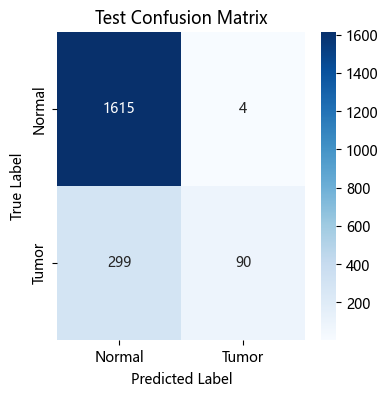

In [49]:
# 加载最佳模型
model.load_state_dict(torch.load(os.path.join(Config.save_dir, "best_model.pth")))
model.eval()

# 在测试集上评估
test_loss, test_preds, test_targets = evaluate(model, test_loader, criterion)
test_auc  = roc_auc_score(test_targets, test_preds)
test_f1   = f1_score(test_targets, (test_preds >= best_thresh).astype(int))
test_acc  = accuracy_score(test_targets, (test_preds >= best_thresh).astype(int))

# 计算混淆矩阵并提取指标
cm = confusion_matrix(test_targets, (test_preds >= best_thresh).astype(int))
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn + 1e-8)  # True Positive Rate
specificity = tn / (tn + fp + 1e-8)  # True Negative Rate

# 打印所有指标
print(f"🧪 Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | "
      f"Test F1: {test_f1:.4f} | Test Acc: {test_acc:.4f}")
print(f"🧪 Test Sensitivity (Recall for tumor): {sensitivity:.4f} | "
      f"Test Specificity (Recall for normal): {specificity:.4f}")

# 绘制测试集混淆矩阵
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Tumor"],
            yticklabels=["Normal", "Tumor"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 保存测试集预测结果
test_df = test_df.copy()
test_df['pred_prob']  = test_preds
test_df['pred_label'] = (test_preds >= best_thresh).astype(int)
test_df.to_csv(os.path.join(Config.save_dir, "test_predictions.csv"), index=False)


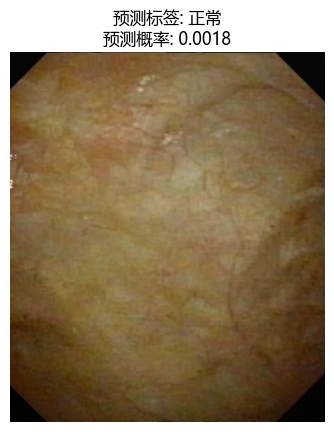

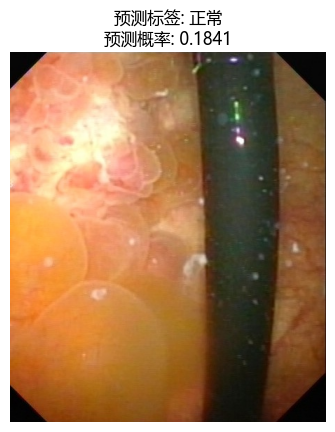

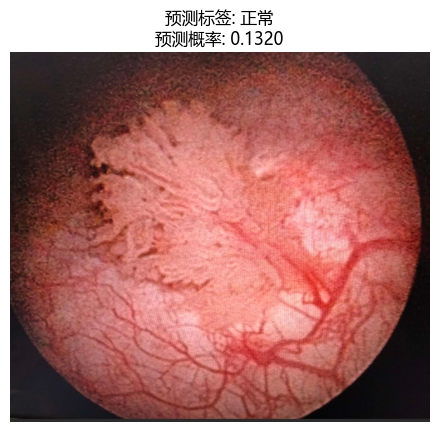

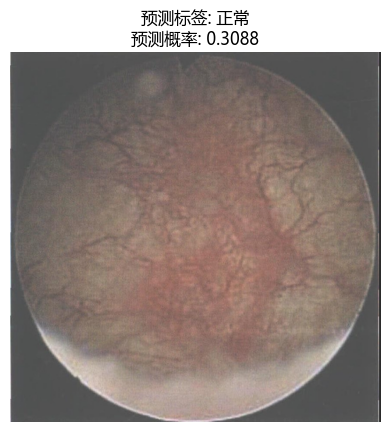

In [51]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib

# ✅ 设置中文字体（以微软雅黑为例）
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# ✅ 加载模型结构（必须与你训练时的结构一致）
#model = TumorClassifier().to(Config.device)
model.load_state_dict(torch.load("D:\\Leko\\medical_model\\task1\\output\\best_model.pth"))
model.eval()

# ✅ 加载你训练时的图像预处理（transform）
infer_transform = get_transforms(train=False)

# ✅ 推理函数
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Apply transform
    transformed = infer_transform(image=image_np)
    input_tensor = transformed['image'].unsqueeze(0).to(Config.device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        label = 1 if prob >= 0.5 else 0

    # 可视化
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"预测标签: {'肿瘤' if label==1 else '正常'}\n预测概率: {prob:.4f}")
    plt.show()

# ✅ 使用示例
predict_image("D:\\Leko\\test1.jpg")
predict_image("D:\\Leko\\test2.jpg")
predict_image("D:\\Leko\\test3.jpg")
predict_image("D:\\Leko\\test4.jpg")

